In [240]:
# import CartPole.py from local directory
import CartPole, sf3utility
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate, scipy.stats.qmc, scipy.optimize
import random, copy, control
import filterpy.kalman, filterpy.common

plt.rcParams["font.family"] = "Georgia"
#plt.rcParams['figure.figsize'] = [9.0, 7.0]
#plt.rcParams['figure.dpi'] = 400

# store results for later
cache = {}

%matplotlib notebook

$$
x_{k+1} = Ax_k + Bu_k + Ke_k
$$
$$
y_k = x_k
$$

In [ ]:
xk1 = A @ xk + B @ uk + K @ ek
xk = yk

In [170]:
N = 512 * 2

# set the random seed and create the sobol sequence generator
np.random.seed(4)
sobol_engine4d = scipy.stats.qmc.Sobol( d=4, seed=4 )
sobol_engine1d = scipy.stats.qmc.Sobol( d=1, seed=4 )

# get N initial states spaced in the recommended ranges and also N initial forces 
X = (sobol_engine4d.random_base2( m=int(np.log2(N)) ).T - 0.5 ) * 2. * np.array( [[ 0.25, 0.25, 0.25, 0.25 ]] ).T# + np.array([0,0,np.pi,0])
U = (sobol_engine1d.random_base2( m=int(np.log2(N)) ).T - 0.5 ) * 2. * 0.25 #np.array( [ 0, 0, 0, 0.25 ] )


# generate the changes in state from these states
Xn_x = np.array( [ CartPole.perform_action_RK4( pad0( state) )[:4] for state in X.T ] ).T
Xn_u = np.array( [ CartPole.perform_action_RK4( fill0(force) )[:4] for force in U.T ] ).T

In [ ]:
A @ X = Xn_x
(A @ X).T = X.T @ A.T = Xn_x.T

B @ U = Xn_u
(B @ U).T = U.T @ B.T = Xn_u.T

In [201]:
AT, Aresiduals, rank, s = np.linalg.lstsq( X.T, Xn_x.T, rcond=None )
BT, Bresiduals, rank, s = np.linalg.lstsq( U.T, Xn_u.T, rcond=None )

A = AT.T
B = BT.T

Bpadded = np.zeros((4,4))
Bpadded[:,3] = B[:,0]

In [202]:
np.around(A, 6), np.around(B, 6), np.around(Bpadded, 6)

(array([[ 1.0000000e+00,  1.9997100e-01, -1.2352700e-01, -6.2730000e-03],
        [-8.0000000e-06,  9.9972500e-01, -1.3288360e+00, -8.8454000e-02],
        [ 2.0000000e-06,  8.8000000e-05,  2.0342670e+00,  2.5885100e-01],
        [ 2.8000000e-05,  9.0300000e-04,  1.1523056e+01,  1.8966050e+00]]),
 array([[ 0.033932],
        [ 0.36028 ],
        [-0.111486],
        [-1.282867]]),
 array([[ 0.      ,  0.      ,  0.      ,  0.033932],
        [ 0.      ,  0.      ,  0.      ,  0.36028 ],
        [ 0.      ,  0.      ,  0.      , -0.111486],
        [ 0.      ,  0.      ,  0.      , -1.282867]]))

# State Space Representation of the System and Closed-Form Control Solutions

The cartpole is a classical control system and as such a lot of the theory we learned in 3F2 can be applied directly. This is an approach that applies only to certain tasks and is not a general machine learning methodology but since it applies so well to this system I have investigated a bit.

The first step is to create a discrete-time linear state-space model of the system with the following form, which assumes small deflections from the equilibrium at the zero state.
$$
x_{k+1} = Ax_k + Bu_k + Ke_k
$$

In this equation, the A matrix is a state transition matrix that describes the effect of the current state $x_k$ on the subsequent state $x_{k+1}$. The B matrix is in this case a column vector, and converts the input force $u_k$ to its effect on the subsequent state. The third term on the right describes noise input to the system.

To find the A and B matrices we could try to linearise the system by hand, but the equations of motion are complex and involve multiple integrator steps per state transition. Another approach is to generate them using least-squares regression similarly to task 1.3. First, set the force input $u_k$ to zero and generate a set of initial state vectors, all close to the zero state. Then, use the cartpole dynamics to update these states. We are left with the equation

$$
X_{k+1} = AX_k
$$

where the capital $X$ represents a matrix formed by stacking the state vectors. This equation is then solved for A using `numpy.lstsq`. A similar approach works for the B matrix, keeping the initial state at 0 and generating a set of force inputs and subsequent states.

In [228]:
control.dlqr(A, Bpadded, np.eye(4) * np.array([0.1,1,5,1]), np.eye(4) * 10)

(array([[  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [ -0.02533298,  -0.14828819, -12.0167036 ,  -1.7515722 ]]),
 array([[   2.91475507,    5.70401983,   17.54966527,    3.23304701],
        [   5.70401983,   31.28649354,   96.96098419,   17.8482968 ],
        [  17.54966527,   96.96098419, 1773.55501898,  266.1379806 ],
        [   3.23304701,   17.8482968 ,  266.1379806 ,   41.54001584]]),
 array([0.94432243+0.02979598j, 0.94432243-0.02979598j,
        0.20931846+0.j        , 0.30018709+0.j        ]))

## Computation of Policy

Having found these two matrices, a discrete linear quadratic regulator (DLQR) is used to find a linear state-feedback controller. The details of this technique are beyond me, involving solving the discrete algebraic Riccati equation, so I used the imported `control.dlqr` function. For the Q matrix I used the identity, and for the R matrix I found that the identity times 100 worked well. This whole process executes almost immediately, compared to the long optimisation process of task 2.3. The policy vector found is p = [ 0.02581708, 0.1272267, 11.95653773, 1.73874922 ] and it is able to stabilise the system.

The policy vector found by this method is similar to the optimised policy vector from task 2.3 in some ways, but different in others. For example, it ascribes a much lower weight to position error, and so the cart takes much longer to reach the origin. It is able to stablise the cart from some initial conditions that the previous policy vector could not, and unable to stabilise from other initial states which the previous policy vector could.

The Q and R matrices play the same role as the loss function from task 2.3 - by varying them, we can encourage the controller to behave in different ways. A large Q matrix encourages fast convergence of the state to zero, but risks reducing stability margins. By varying the diagonal elements of the Q matrix, different elements of the state vector can be given higher priorities to bring to zero. The R matrix similarly penalises the force input. The DLQR policy has not been able to learn the nonlinearities of the system, so could be at a disadvantage in performance. This manifests as the policy taking longer to bring all the states to zero - it cannot rely on nonlinear quirks to help speed up the convergence so is more cautious with the force input.

<IPython.core.display.Javascript object>


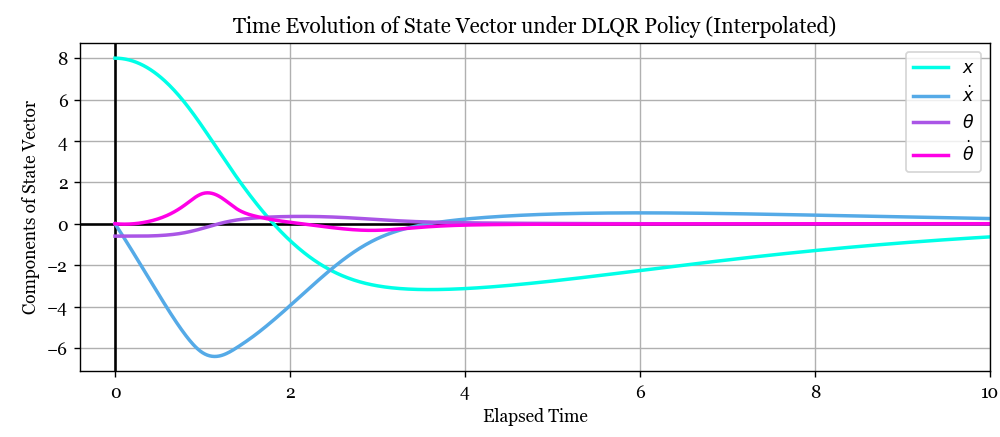

(-0.4, 10.0)

In [291]:
fig, ax = plt.subplots(1, 1, num=66, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.08, right=0.99)
sf3utility.setup_phase_portrait( ax )

# small oscillations about stable equilibrium

state = np.array( [ 8, 0, -0.6, 0, 0 ] )
#p = - np.array( [ -0.20792587, -0.4554855, -12.8760437,  -1.92181886, 0 ] ) # dlqr!!
p = - np.array( [ -0.02581708,  -0.1272267 , -11.95653773,  -1.73874922, 0] ) # dlqr!! big R

states = []
time = []

for i in range(55):
    
    states.append( state )
    time.append( i * 0.2 )

    clipped_state = state
    #clipped_state[0] = np.clip( state[0], -2, 2 )

    state[4] = p @ clipped_state
    state = CartPole.perform_action_RK4( state )

states = np.array( states )
time = np.array( time )

x = time
y = states

col_lerp = np.linspace(0, 1, 4)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255

labels = ["$x$","$\dot{x}$","$θ$","$\dot{θ}$"]

for i in range(4):
    
    f2 = scipy.interpolate.interp1d(x, y[:,i], kind='cubic')

    xnew = np.linspace(0, time[-1], 800)
    
    ax.plot( xnew, f2(xnew), color=colours[i], label=labels[i], linewidth=2 )

ax.set_title( "Time Evolution of State Vector under DLQR Policy (Interpolated)" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Components of State Vector" )
ax.legend(loc="upper right")

# ax.set_ylim( -5, 5 )
ax.set_xlim( -0.4, 10 )

Above is a typical state vector time evolution under the DLQR policy. It is clear that this policy brings the states to zero much more gradually. So task 2.3 is solved to a reasonable standard in a few lines and almost instantly. The takeaway is that by applying our experience as data scientists, the underlying structure of many problems can be revealed to allow more elegant solutions.

## Introduction of Noise

The state-space representation of the system enables application of Kalman Filtering or other noise handling techniques. Linear Quadratic Gaussian control is ideal for this scenario but I did not have time to implement this and I imagine the lag introduced by the Kalman filter would cause issues with controlling the cartpole.

One interesting effect I noticed is that by varying the Q and R matrices, the tolerance to noise can be increased. The above controller with the large R matrix was much more tolerant to process noise than any other policy I had created so far. I think the different loss function definition led to the controller being less desperate to quickly bring the cart to the origin. It was then more able to keep the pole up since the force inputs to bring the  cart to the centre were less erratic.

<IPython.core.display.Javascript object>


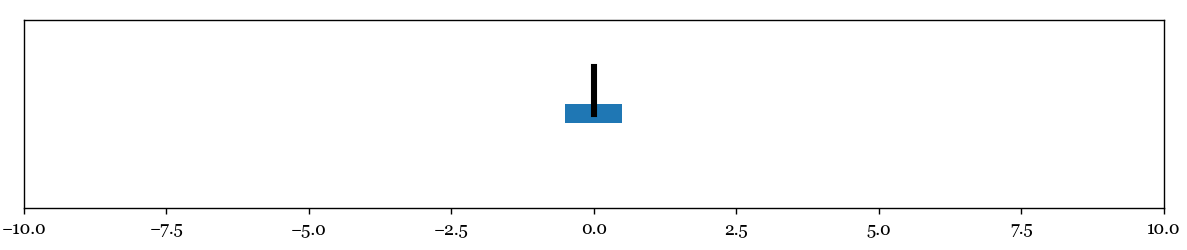

In [338]:
cart_pole = CartPole.CartPole( visual=True, save_frames=False, fig_num=58 )

state = np.array( [[ 0, 0, 0., 0 ]] ).T
#p = - np.array( [[-0.20792587, -0.4554855, -12.8760437,  -1.92181886]] ) # dlqr!!
#p = - np.array( [[-0.42004789,  -0.754576  , -13.5778077 ,  -2.08834533]] ) # dlqr!! small R
p = - np.array( [[ -0.02581708,  -0.1272267 , -11.95653773,  -1.73874922]] ) # dlqr!! big R

force = 0

cart_pole.set_state( state )
cart_pole._render()

In [310]:
means = np.array([[ 2.00951924, 1.964584, 1.98959769, 4.76029465]]).T

kalman_filter = filterpy.kalman.KalmanFilter( dim_x=4, dim_z=4 )
kalman_filter.x = state # initial state
kalman_filter.F = A # state transition matrix
kalman_filter.H = np.eye(4) # measurement function
kalman_filter.P = np.eye(4) * 0 # uncertainty
kalman_filter.R = 0.02 # measurement noise
kalman_filter.Q = 0 # filterpy.common.Q_discrete_white_noise(dim=4, dt=0.2, var=0.02**2) # process noise

In [313]:


for i in range(50):
    
    noisy_state = state + np.random.randn(4, 1) * 0.02
    
    force = p @ noisy_state
    state = A @ state + B * force
    cart_pole.set_state( state )
    cart_pole._render()

<IPython.core.display.Javascript object>


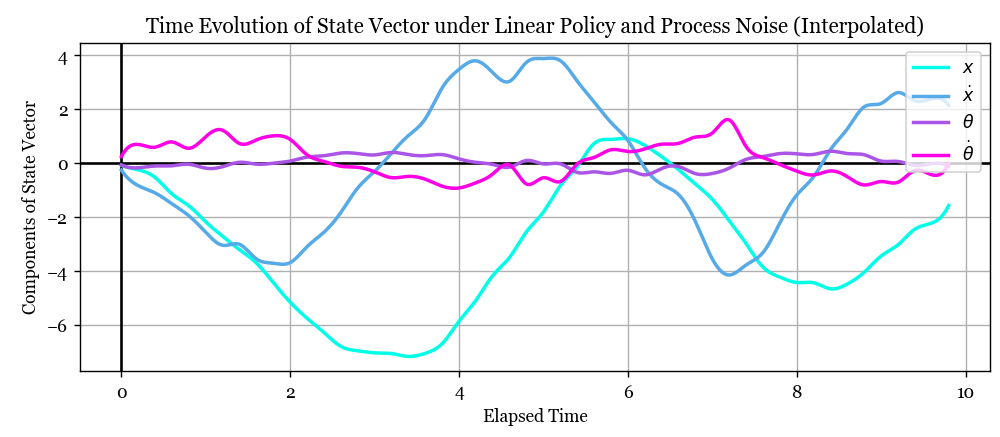

In [337]:
means = np.array([ 2.00951924, 1.964584, 1.98959769, 4.76029465, 0 ])

np.random.seed(3)

fig, ax = plt.subplots(1, 1, num=35, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.08, right=0.99)
sf3utility.setup_phase_portrait( ax )

p = np.array([0.75971638,  1.44284499, 17.05744679,  2.66183469, 0])
p_dlqr = - np.array( [ -0.02581708,  -0.1272267 , -11.95653773,  -1.73874922, 0] ) # dlqr!! big R

state = np.array([0., 0, 0, 0, 0])
dlqr_state = np.array([0., 0, 0, 0, 0])

times = []
states = []
dlqr_states = []

noise_level = 0.07

for i in range(50):
    
    state = state + np.random.randn( 5 ) * means * noise_level
    dlqr_state = dlqr_state + np.random.randn( 5 ) * means * noise_level

    state[4] = p @ state
    dlqr_state[4] = p_dlqr @ dlqr_state
    
    state = CartPole.perform_action_RK4( state )
    dlqr_state = CartPole.perform_action_RK4( dlqr_state )
    
    
    times.append( i * 0.2 )
    states.append( state )
    dlqr_states.append( dlqr_state )

times = np.array( times )
states = np.array( states )
dlqr_states = np.array( dlqr_states )

x = times
y = dlqr_states

col_lerp = np.linspace(0, 1, 4)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255

labels = ["$x$","$\dot{x}$","$θ$","$\dot{θ}$"]

for i in range(4):
    
    f2 = scipy.interpolate.interp1d(x, y[:,i], kind='cubic')

    xnew = np.linspace(0, times[-1], 800)
    
    ax.plot( xnew, f2(xnew), color=colours[i], label=labels[i], linewidth=2 )

ax.set_title( "Time Evolution of State Vector under Linear Policy and Process Noise (Interpolated)" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Components of State Vector" )
ax.legend(loc="upper right")
